In [2]:
import pandas as pd
import numpy as np
import wrds
import re
import requests
from fredapi import Fred
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from dotenv import load_dotenv
import os
import warnings
import joblib

In [3]:
conn = wrds.Connection(wrds_username="nberzins")

Enter your WRDS username [nberzins]: nberzins
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  n


You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
conn.describe_table(library= "crsp", table='dsf')

Approximately 107663472 rows in crsp.dsf.


,name,nullable,type,comment
0,cusip,True,VARCHAR(8),CUSIP Header
1,permno,True,INTEGER,PERMNO
2,permco,True,INTEGER,PERMCO
3,issuno,True,INTEGER,Nasdaq Issue Number
4,hexcd,True,SMALLINT,Exchange Code Header
5,hsiccd,True,INTEGER,Standard Industrial Classification Code Header
6,date,True,DATE,Date of Observation
7,bidlo,True,"NUMERIC(11, 5)",Bid or Low Price
8,askhi,True,"NUMERIC(11, 5)",Ask or High Price
9,prc,True,"NUMERIC(11, 5)",Price or Bid/Ask Average


In [33]:
sp500 = conn.raw_sql("""
                        SELECT a.*, b.date, b.ret, b.prc, b.shrout
                        FROM crsp.dsp500list as a, crsp.dsf as b
                        WHERE a.permno=b.permno
                            AND b.date >= a.start and b.date <= a.ending
                            AND b.date >= '01/01/2000'
                        ORDER BY date; 
                        """, date_cols=['start', 'ending', 'date'])

In [40]:
sp500["mktcap"] = np.absolute(sp500["prc"]) * sp500["shrout"]

In [41]:
dse = conn.raw_sql("""
                        SELECT comnam, namedt, nameendt, permno, siccd
                        FROM crsp.dsenames
                        """, date_cols=['namedt', 'nameendt'])

dse['Major Group'] = dse['siccd'] // 100

In [42]:
sic_groups = pd.read_csv("SIC_Major_Groups.csv")

dse = pd.merge(dse, sic_groups, how='left', on='Major Group')

In [43]:
fama_five = conn.raw_sql("""
                            SELECT *
                            FROM ff.fivefactors_daily as ff
                            WHERE ff.date >= '01/01/2000'
                            """)

fama_five["date"] = pd.to_datetime(fama_five["date"], format='%Y-%m-%d')

fama_five.tail(5)

,date,mktrf,smb,hml,rmw,cma,rf,umd
6284,2024-12-24,0.0111,-0.0012,-0.0005,-0.0013,-0.0037,0.00017,0.0067
6285,2024-12-26,0.0002,0.0109,-0.0019,-0.0044,0.0035,0.00017,0.0001
6286,2024-12-27,-0.0117,-0.0044,0.0056,0.0041,0.0003,0.00017,-0.0088
6287,2024-12-30,-0.0109,0.0024,0.0074,0.0055,0.0014,0.00017,0.0006
6288,2024-12-31,-0.0046,0.0031,0.0071,0.0033,0.0,0.00017,-0.0107


In [44]:
load_dotenv()

fred_api_key = os.getenv("FRED_API_KEY")

fred = Fred(api_key = fred_api_key)
fed_funds = fred.get_series('FEDFUNDS', observation_start='2000-01-01', observation_ends='2024-01-12')

In [45]:
ffer_df = fed_funds.to_frame(name="fed_funds_rate").reset_index()

ffer_df.describe()
ffer_df = ffer_df.rename(columns={"index": "date", "fed_funds_rate": "fed_funds_rate"})

ffer_df["date"] = pd.to_datetime(ffer_df["date"], format="%Y-%d-%m")
ffer_df["date"] = ffer_df["date"].dt.strftime('%Y-%m-%d')
ffer_df["date"] = pd.to_datetime(ffer_df["date"], format="%Y-%m-%d")

ffer_df = ffer_df[:-4]
ffer_df["fed_funds_rate"] = ffer_df["fed_funds_rate"] / 100
ffer_df

,date,fed_funds_rate
0,2000-01-01,0.0545
1,2000-02-01,0.0573
2,2000-03-01,0.0585
3,2000-04-01,0.0602
4,2000-05-01,0.0627
...,...,...
295,2024-08-01,0.0533
296,2024-09-01,0.0513
297,2024-10-01,0.0483
298,2024-11-01,0.0464


In [46]:
#Merging returns w/ company info

sp500_full = pd.merge(sp500, dse, how='left', on='permno')
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                             & (sp500_full.date<=sp500_full.nameendt)]

# Merging fama french factors and complete sp500 data

sp500_full = pd.merge(sp500_full, fama_five, how='left', on='date')

#Merging Federal Funds Rate Data 
#because only working with monthly values, have to break up the data into year and month then join on those two columns

sp500_full["month"] = sp500_full["date"].dt.month
sp500_full["year"] = sp500_full["date"].dt.year

ffer_df["month"] = ffer_df["date"].dt.month
ffer_df["year"] = ffer_df["date"].dt.year

#getting rid of unneccesary date column to avoid repeat column naames post-merge
ffer_df = ffer_df.drop(columns=["date"])

sp500_full = pd.merge(sp500_full, ffer_df, on=["year","month"], how="left")

# Removing now unnecessary month/year columns & repeat
sp500_full = sp500_full.drop(columns=["month", "year"])


In [47]:
# Date str --> Datetime conversion
sp500_full["date"] = pd.to_datetime(sp500_full["date"], format='%Y-%m-%d')

# ret, mktrf, smb, etc. --> log returns conversion
# Log-returns prove additive and will not impact future return-based factor calculations

cols_to_log = ["ret", "mktrf", "smb", "hml", "rmw", "cma", "rf", "fed_funds_rate"]
sp500_full[cols_to_log] = np.log1p(sp500_full[cols_to_log])

In [48]:
sp500_full

,permno,start,ending,date,ret,prc,shrout,mktcap,comnam,namedt,...,Major Group,Group Name,mktrf,smb,hml,rmw,cma,rf,umd,fed_funds_rate
0,14322,1925-12-31,2005-03-24,2000-01-03,-0.010341,30.0625,377954.0,11362242.125,SEARS ROEBUCK & CO,1968-01-02,...,53,General Merchandise Stores,-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
1,59184,1976-07-01,2008-11-18,2000-01-03,-0.012423,70.0,465290.0,32570300.0,ANHEUSER BUSCH COS INC,1980-04-18,...,20,Food And Kindred Products,-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
2,12650,1999-04-05,2000-07-12,2000-01-03,-0.056862,70.5,110524.0,7791942.0,KANSAS CITY SOUTHERN INDS INC,1968-01-02,...,40,Railroad Transportation,-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
3,76887,1999-08-02,2008-12-04,2000-01-03,-0.043485,8.4375,188848.0,1593405.0,ALLIED WASTE INDUSTRIES INC,1998-12-30,...,49,"Electric, Gas, And Sanitary Services",-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
4,42534,1986-05-08,2016-09-02,2000-01-03,-0.016621,55.9375,85404.0,4777286.25,JOHNSON CONTROLS INC,1974-12-02,...,38,"Measuring, Analyzing, And Controlling Instrume...",-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155298,20057,2020-11-17,2024-12-31,2024-12-31,0.005638,12.45,1193593.0,14860232.85,VIATRIS INC,2021-03-25,...,99,Nonclassifiable Establishments,-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825
3155299,76744,2013-09-23,2024-12-31,2024-12-31,0.008354,402.70001,257529.0,103706930.87529,VERTEX PHARMACEUTICALS INC,2004-06-10,...,28,Chemicals And Allied Products,-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825
3155300,27959,1976-07-01,2024-12-31,2024-12-31,0.000279,107.74,772482.0,83227210.68,DUKE ENERGY CORP NEW,2014-02-03,...,49,"Electric, Gas, And Sanitary Services",-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825
3155301,85913,1998-05-21,2024-12-31,2024-12-31,-0.004899,278.94,277893.0,77515473.42,MARRIOTT INTERNATIONAL INC NEW,2013-10-21,...,70,"Hotels, Rooming Houses, Camps, And Other Lodgi...",-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825


**Store Data As CSV to avoid long pull request times from WRDS**

In [4]:
# sp500_full.to_csv("sp500_full.csv", index = False)

sp500_full = pd.read_csv("sp500_full.csv")
sp500_full["date"] = pd.to_datetime(sp500_full["date"])
sp500_full = sp500_full.dropna()

### Notable Industry Codes
- 50-59 = General Retail
- 60 = Depository Institutions (Banking)
- 63 = Insurance Carriers
- 73 = Business Services (Tech)
- 80 = Health Services

In [5]:
# MUST BE: "Daily", "Weekly", or "Monthly"

def get_anomalies(time_frame="Monthly"):

    anomalies_dict = {}

    parent_path = f"./Anomaly Factors/{time_frame}/"
    
    folders = os.listdir(parent_path)
    
    for folder in folders:
        #get parent folder path
        path = f"{parent_path}{folder}/"
        files = os.listdir(path)
    
        for file in files:
            #get file path       
            file_path = f"{path}{file}"
            
            #get raw data
            df = pd.read_csv(file_path)

            if time_frame == "Daily":
    
                #Handilng Date Column
                df["DATE"] = pd.to_datetime(df['DATE'].astype(str), format='%Y%m%d')
                df = df[df["DATE"] >= pd.to_datetime("2000-01-01")]
        
                #getting rank and ret column names
                rank_col = df.columns[1]
                ret_col = df.columns[3]
        
                # #### High Minus Low Spread Return ####
        
                # # Selecting Rows only where the decile is either 1 or 10 
                # d10 = df[df[rank_col] == 10][["DATE", ret_col]].rename(columns={ret_col: "D10"})
                # d1 = df[df[rank_col] == 1][["DATE", ret_col]].rename(columns={ret_col: "D1"})
        
                # # Merge and compute spread
                # df_filt = pd.merge(d10, d1, on="DATE")
                # df_filt["HML_ret"] = df_filt["D10"] - df_filt["D1"]
        
                #### Average of Deciles ####
        
                df_filt = df.groupby("DATE")[ret_col].mean().reset_index(name = "DecileMean_Ret") 
                df_filt[f"log_{ret_col}"] = np.log1p(df_filt["DecileMean_Ret"] / 100) #ensuring log returns for consistency/mutability
        
                #### Rank-Weighted Return ####
        
                # A proxy for linear factor return
                
                #### Count-Weighted Return ####
        
                # Handling that some deciles are calculated from fewer or greater securities than others for every given day

                match = re.search(r"^portf(.*?)_daily_2024\.csv", file)
                anomaly_name = match.group(1).lstrip("_")
                
                anomalies_dict[anomaly_name] = df_filt

            elif time_frame == "Weekly":
                # NOT CURRENTLY WORKING WITH WEEKLY
                pass
            else: #Monthly

                #Handilng Date Column
                df["DATE"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
                df['DATE'] = pd.to_datetime(df['DATE'])
                df = df[df['DATE'] >= pd.to_datetime("2000-01-01")]

                #Dropping unnecessary columns for readability, then moving DATE to replicate the daily format
                df.drop(columns = ["year", "month"], inplace = True)
                cols = ["DATE"] + [col for col in df.columns if col != "DATE"]
                
                df = df[cols]

                  
                #getting rank and ret column names
                rank_col = df.columns[1]
                ret_col = df.columns[3]
        
                # #### High Minus Low Spread Return ####
        
                # # Selecting Rows only where the decile is either 1 or 10 
                # d10 = df[df[rank_col] == 10][["DATE", ret_col]].rename(columns={ret_col: "D10"})
                # d1 = df[df[rank_col] == 1][["DATE", ret_col]].rename(columns={ret_col: "D1"})
        
                # # Merge and compute spread
                # df_filt = pd.merge(d10, d1, on="DATE")
                # df_filt["HML_ret"] = df_filt["D10"] - df_filt["D1"]
        
                #### Average of Deciles ####
        
                df_filt = df.groupby("DATE")[ret_col].mean().reset_index(name = "DecileMean_Ret") 
                df_filt[f"log_{ret_col}"] = np.log1p(df_filt["DecileMean_Ret"] / 100) #ensuring log returns for consistency/mutability
        
                #### Rank-Weighted Return ####
        
                # A proxy for linear factor return
                
                #### Count-Weighted Return ####
        
                # Handling that some deciles are calculated from fewer or greater securities than others for every given day
    
                match = re.search(r"^portf(.*?)_monthly_2024\.csv", file)
                anomaly_name = match.group(1).lstrip("_")
                
                anomalies_dict[anomaly_name] = df_filt

    return anomalies_dict

### Daily Dictionaries

#### Obtaining Daily Anomaly Portfolios

In [6]:
anomalies_daily_dict = get_anomalies("Daily")

In [7]:
warnings.filterwarnings("ignore")

first_key = next(iter(anomalies_daily_dict))
merged_anomalies = anomalies_daily_dict[first_key][["DATE"]].copy()

for key, df in anomalies_daily_dict.items():

    log_col = [col for col in df.columns if col.startswith("log_")][0]

    merged_anomalies[key] = df[log_col].values

merged_anomalies["DATE"] = pd.to_datetime(merged_anomalies["DATE"])

#### Daily SP500 Returns

In [8]:
# Calculating Volatility

sp500_full["volatility_21d"] = (
    sp500_full.groupby("comnam")["ret"]
    .rolling(window=21, min_periods=1)
    .std()
    .reset_index(level=0, drop = True)
    .fillna(0))

# Calculating 5 day Short-term reversal

sp500_full["5d_reversal"] = -(
    sp500_full.groupby("comnam")["ret"]
    .rolling(window=5, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
    .fillna(0)

)

# Calculating 1 day lagged short-term reversal

sp500_full["1d_lag_reversal"] = -(
    sp500_full.groupby("comnam")["ret"].shift(1)
    .fillna(0)
)

#### Merging SP500 Daily with Anomalies and Converting to Dictionary

In [9]:
sp500_anom = sp500_full.merge(merged_anomalies, how = "left", left_on = "date", right_on = "DATE")
sp500_anom.drop(columns=["DATE"], inplace = True)

In [10]:
factor_cols = sp500_anom.columns.tolist()[14:]

sp500_dly = {
    name: group[["date", "Major Group", "ret"] +factor_cols].reset_index(drop=True)
    for name, group in sp500_anom.groupby("comnam")
}

sp500_dly["ALPHABET INC"]

#CHECK REPEAT ROWS ISSUE

,date,Major Group,ret,mktrf,smb,hml,rmw,cma,rf,umd,...,op,rev_12,rev_1,rev_6,spq_12,spq_1,spq_6,sp,vfp,vhp
0,2015-10-05,73,0.022114,0.019116,0.007373,0.007671,0.001099,0.005982,0.00000,-0.0196,...,0.019661,0.020344,0.021064,0.020290,0.021294,0.021562,0.021222,0.021115,0.020171,0.019226
1,2015-10-05,73,0.022959,0.019116,0.007373,0.007671,0.001099,0.005982,0.00000,-0.0196,...,0.019661,0.020344,0.021064,0.020290,0.021294,0.021562,0.021222,0.021115,0.020171,0.019226
2,2015-10-06,73,0.006170,-0.004309,-0.000900,0.016365,0.003394,0.005485,0.00000,-0.0306,...,-0.004012,-0.002014,-0.001542,-0.001927,-0.002831,-0.002369,-0.003144,-0.002390,-0.002121,-0.003087
3,2015-10-06,73,-0.000060,-0.004309,-0.000900,0.016365,0.003394,0.005485,0.00000,-0.0306,...,-0.004012,-0.002014,-0.001542,-0.001927,-0.002831,-0.002369,-0.003144,-0.002390,-0.002121,-0.003087
4,2015-10-07,73,-0.002445,0.009356,0.007770,-0.002403,-0.001301,0.001000,0.00000,-0.0033,...,0.010420,0.009828,0.010261,0.009924,0.010092,0.010876,0.010359,0.009864,0.009979,0.009648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4647,2024-12-27,73,-0.015647,-0.011769,-0.004410,0.005584,0.004092,0.000300,0.00017,-0.0088,...,-0.010181,-0.009715,-0.009348,-0.009543,-0.008525,-0.008462,-0.008468,-0.008812,-0.008446,-0.009265
4648,2024-12-30,73,-0.007916,-0.010960,0.002397,0.007373,0.005485,0.001399,0.00017,0.0006,...,-0.010175,-0.010637,-0.010962,-0.010762,-0.009766,-0.009814,-0.009804,-0.009683,-0.010295,-0.009392
4649,2024-12-30,73,-0.006981,-0.010960,0.002397,0.007373,0.005485,0.001399,0.00017,0.0006,...,-0.010175,-0.010637,-0.010962,-0.010762,-0.009766,-0.009814,-0.009804,-0.009683,-0.010295,-0.009392
4650,2024-12-31,73,-0.011746,-0.004611,0.003095,0.007075,0.003295,0.000000,0.00017,-0.0107,...,-0.002926,-0.001593,-0.001022,-0.001504,0.001189,0.001212,0.001333,0.000645,0.000044,-0.001351


### Weekly Dictionaries

#### Obtaining Weekly Anomaly Portfolios

#### Weekly SP500 Returns

In [5]:
factor_cols = ["ret", "mktrf", "smb", "hml", "rmw", "cma", "rf"]
sp500_wkly = {}

for name, df in sp500_dly.items():

    #Converting to Weekly
    df = df.copy()
    df = df.drop(columns=["umd", "fed_funds_rate", "volatility_21d", "5d_reversal", "1d_lag_reversal"])
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    
    weekly_df = df[factor_cols].resample("W-MON", label="left", closed="left").sum().reset_index()

    # Adding 1-yr (lagged) momentum
    weekly_df["momentum_52w"] = (
        weekly_df["ret"]
        .shift(4)
        .rolling(window=52, min_periods=40)
        .sum()
    )

    # 4 (to 8) Week Volatility
    vol_window = 4
    weekly_df["volatility"] = weekly_df["ret"].rolling(window=vol_window, min_periods=3).std() 
    
    sp500_wkly[name] = weekly_df

sp500_wkly["GENERAL ELECTRIC CO"]

,date,ret,mktrf,smb,hml,rmw,cma,rf,momentum_52w,volatility
0,2000-01-03,-0.022465,-0.025204,-0.003856,0.006009,-0.008693,0.021395,0.00105,NaN,NaN
1,2000-01-10,-0.002068,0.020484,0.013664,-0.015142,-0.028502,0.000921,0.00105,NaN,NaN
2,2000-01-17,-0.046600,0.000377,0.058498,-0.026008,-0.049815,0.001161,0.00084,NaN,0.022292
3,2000-01-24,-0.072843,-0.058778,0.008962,0.016715,0.013913,0.016285,0.00105,NaN,0.030574
4,2000-01-31,0.054902,0.043595,-0.001359,-0.026716,-0.020247,-0.013999,0.00109,NaN,0.055937
...,...,...,...,...,...,...,...,...,...,...
1300,2024-12-02,-0.036789,0.010163,-0.013489,-0.030582,-0.008357,-0.013135,0.00085,0.706034,0.032570
1301,2024-12-09,-0.056047,-0.009292,-0.009654,-0.001631,0.024498,-0.012535,0.00085,0.622827,0.036817
1302,2024-12-16,0.014116,-0.022998,-0.019514,-0.014670,-0.009697,0.006406,0.00085,0.646063,0.033599
1303,2024-12-23,0.011751,0.005551,-0.003306,0.001281,0.001177,0.006665,0.00068,0.630755,0.035170


### Monthly Dictionaries

#### Merged SP500 Monthly with Anomalies and Conveting to Dict

#### Wrangling Monthly SP500 Returns and Anomalies

In [11]:
first_cols = ["Major Group", "ret"]
factor_cols = [col for col in sp500_anom.columns.tolist()[14:] if col != "DATE"]
factor_cols = first_cols + factor_cols

sp500_monthly = {}

for name, df in sp500_dly.items():

    #Converting to Monthly
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"]) # double checking date time conversion
    df.set_index("date", inplace=True)

    monthly_df = df[factor_cols].resample("MS",                              # Given only factor columns resample data to month start
                                          label="left",                      # And lable it with the start of the month
                                          closed="left").sum().reset_index() # And include the first day of the month and exclude the end

    if len(monthly_df) >= 30: #If company had less than 30 months in the S&P 500, do not include for future analysis

        #Don't lose the major group value in conversion
        major_group_value = df["Major Group"].dropna().iloc[-1]
        monthly_df["Major Group"] = major_group_value
        #Make sure cols are in right position
        cols = monthly_df.columns.tolist()
        cols.remove("Major Group")
        cols.insert(1, "Major Group")
        monthly_df = monthly_df[cols]
    
    
        #Adding 1-yr (lagged) momentum
        monthly_df["momentum_12m"] = (
            monthly_df["ret"].shift(1).rolling(window=12, min_periods=10).sum()
        )
    
        # 3 (to 6) Month Volatility 
        vol_window = 3
        monthly_df["volatility"] = monthly_df["ret"].rolling(window=vol_window, min_periods=2).std()
    
        monthly_df = monthly_df.dropna(axis=0) #getting rid of rows without calculated factor values due
                                               #to necessary rolling window
    
        #If the company has at least 1 years worth of data, proceed to analysis
        if monthly_df.shape[0] >= 2:
    
            sp500_monthly[name] = {"data": monthly_df}
    
        #If the comapny doesnt have at least 1 years worth of data, do nothing
        #Will not be added to sp500_monthly
        else:
            pass

In [12]:
joblib.dump(sp500_monthly, "sp500_monthly.joblib", compress=3)


['sp500_monthly.joblib']

In [3]:
sp500_monthly = joblib.load("sp500_monthly.joblib")

#### Testing Initial Models and Checking Output

In [4]:
import difflib

test_comps = ["APPLE INC", "GENERAL ELECTRIC CO", "MICROSOFT CORP"]

available_keys = list(sp500_monthly.keys())
selected = {}
missing = []

for comp in test_comps:
    # exact match
    if comp in sp500_monthly:
        selected[comp] = sp500_monthly[comp]
        continue

    # case-insensitive exact
    ci = next((k for k in available_keys if k.lower() == comp.lower()), None)
    if ci:
        selected[ci] = sp500_monthly[ci]
        continue

    # fuzzy match (optional, cutoff adjust as needed)
    close = difflib.get_close_matches(comp, available_keys, n=1, cutoff=0.7)
    if close:
        k = close[0]
        selected[k] = sp500_monthly[k]
        continue

    missing.append(comp)

# results
sp500_monthly_test = selected                     # full dict entries (with "data" and "models")
sp500_monthly_test_df = {k: v["data"] for k, v in selected.items()}  # only DataFrames

print("Requested:", test_comps)
print("Found keys:", list(sp500_monthly_test.keys()))
if missing:
    print("Missing (no match):", missing)

Requested: ['APPLE INC', 'GENERAL ELECTRIC CO', 'MICROSOFT CORP']
Found keys: ['APPLE INC', 'GENERAL ELECTRIC CO', 'MICROSOFT CORP']


In [25]:
sp500_monthly_test["APPLE INC"]["data"].columns

Index(['date', 'Major Group', 'ret', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf',
       'umd',
       ...
       'rev_1', 'rev_6', 'spq_12', 'spq_1', 'spq_6', 'sp', 'vfp', 'vhp',
       'momentum_12m', 'volatility'],
      dtype='object', length=215)

In [8]:
def flatten_panel(sp500_monthly_test):
    frames = []
    for comp_name, node in sp500_monthly_test.items():
        df = node["data"].copy()
        df["comp_name"] = comp_name
        frames.append(df)
    panel = pd.concat(frames, ignore_index=True)
    # basic hygiene
    panel["date"] = pd.to_datetime(panel["date"])
    panel = panel.sort_values(["comp_name", "date"]).reset_index(drop=True)
    return panel

#### Making Neural Networks

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [10]:
# FNN
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(FNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1) # Output: predicted return or SDF score
        ) 

    def forward(self, x):
        return self.net(x)

**LSTM Prep**

In [ ]:
# LSTM
temp_flat = flatten_panel(sp500_monthly)

temp = temp_flat.sort_values(['comp_name', 'date']).copy()

# target: next-month return
temp['y'] = temp.groupby('comp_name')['ret'].shift(-1)

# stable indices for embeddings 
firm_vocab = {f:i for i,f in enumerate(sorted(temp['comp_name'].unique()))}
temp['firm_idx'] = temp['comp_name'].map(firm_vocab)

ind_vocab = {g:i for i,g in enumerate(sorted(temp['Major Group'].unique()))}
temp['industry_idx'] = temp['Major Group'].map(ind_vocab)



In [ ]:
#------------------------
# 1) CONFIG
#------------------------

LOOKBACK = 12      # months of history per sequence
HORIZON = 1        # predict the next month
BATCH = 256
EPOCHS = 50
LR = 1e-3
HIDDEN = 64
EMB_FIRM = 16      # firm embedding dim
EMB_IND = 8        # industry embedding dim (optional)
DROPOUT = 0.2     

ALL_COLS = list(temp.columns)
start_idx = ALL_COLS.index('ret') + 1
FEATURE_COLS = [c for c in ALL_COLS[start_idx:] if c not in ['y', 'firm_idx', 'industry_idx']]

#------------------------
# 2) TIME SPLITS
#------------------------

folds = [
    (pd.Timestamp('2010-12-31'), pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31')),
    (pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31')),
    (pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31')),
    (pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31')),
    (pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31')),
    (pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31'), pd.Timestamp('2024-12-31'))
]

min_date = temp['date'].min()

def mask_by_range(d0, d1):
    return(temp['date'] > d0) & (df['date'] <= d1)

#------------------------
# 3) SEQUENCE BUILDER
#------------------------

def make_sequences(frame, lookback=LOOKBACK):
    # frame must already be filtered by date
    data = []
    grp = frame.sort_values(['comp_name','date']).groupby('comp_name', sort=False)
    Xnames = FEATURE_COLS
    for fid, g in grp:
        g = g.dropna(subset=Xnames + ['y','firm_idx','industry_idx'])  # keep safe rows
        X = g[Xnames].values
        y = g['y'].values
        firm_idx = int(g['firm_idx'].iloc[0])  # constant per firm
        ind = g['industry_idx'].values  # could vary; we’ll use last step’s industry
        for t in range(lookback-1, len(g)-HORIZON):
            X_seq = X[t-lookback+1:t+1, :]                 # [Last L months up to t, F]
            y_next = y[t + HORIZON]                        # scalar
            ind_last = int(ind[t])                         # industry at time t
            data.append((X_seq, y_next, firm_idx, ind_last))
    # Stack
    X_seqs = np.stack([d[0] for d in data]) if data else np.empty((0,lookback,len(Xnames)))
    y_vec  = np.array([d[1] for d in data], dtype=np.float32)
    f_idx  = np.array([d[2] for d in data], dtype=np.int64)
    i_idx  = np.array([d[3] for d in data], dtype=np.int64)
    return X_seqs, y_vec, f_idx, i_idx

class PanelSeqDataset(Dataset):
    def __init__(self, X, y, firm_idx, ind_idx):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        self.f = torch.tensor(firm_idx, dtype=torch.long)
        self.i = torch.tensor(ind_idx, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.f[idx], self.i[idx], self.y[idx]
    
#------------------------
# 4) MODEL (LSTM + embeddings)
#------------------------

class GlobalLSTM(nn.Module):
    def __init__(self, n_features, n_firms, n_inds,
                 hidden = HIDDEN, emb_firm = EMB_FIRM, emb_ind = EMB_IND, 
                 dropout=DROPOUT):
        super().__init__()
        self.emb_firm = nn.Embedding(n_firms, emb_firm)
        self.emb_ind = nn.Embedding(n_inds, emb_ind)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden,
                            num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        # concat [h_t, e_firm, e_ind] -> MLP head
        self.head = nn.Sequential(
            nn.Linear(hidden + emb_firm + emb_ind, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64,1)
        )
    def forward(self, x, firm_idx, ind_idx):
        # x: [Batch Size, Sequence Length (Lookback), Feature Dimension]
        out, (h_T, c_T) = self.lstm(x)
        h = h_T[-1]
        ef = self.emb_firm(firm_idx)
        ei = self.emb_ind(ind_idx)
        z = torch.cat([h, ef, ei], dim=1)
        z = self.dropout(z)
        yhat = self.head(z)
        return yhat

#------------------------
# 5) TRAIN / EVAL HELPERS
#------------------------
def train_one(model, opt, crit, loader, device):
    model.train()
    total = 0.0
    for X, f, i, y in loader:
        X,f,i,y = X.to(device), f.to(device), i.to(device), y.to(device)

#### Training Models

In [ ]:
for name, info in sp500_monthly_test.items():

    df = info["data"] 
    X = df.iloc[:, 3:] #skip first two columns (date and returns)
    y = df["ret"].to_numpy()
    
    cutoff = round(len(X) * .8)

    X_train = X.iloc[:cutoff , :]
    X_test = X.iloc[cutoff:, :]

    y_train = y[:cutoff]
    y_test = y[cutoff:]


    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lin_model = LinearRegression().fit(X_train_scaled, y_train)

    alphas = np.logspace(-3, 0, 30) #30 values between 0.001 and 1
    lasso_model = LassoCV(alphas = alphas, cv = 5, max_iter = 5000).fit(X_train_scaled, y_train)
    
    pcr_model = Pipeline([
        ("pca", PCA(n_components=0.95)),
        ("reg", LinearRegression())
    ]).fit(X_train_scaled,y_train)

    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ).fit(X_train_scaled, y_train)

    #Setting up tensors for Neural Networks

    X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)

    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

    input_dim = X_train_scaled.shape[1]
    fnn_model = FNN(input_dim)
    optimizer = optim.Adam(fnn_model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    #FNN Training Loop
    for epoch in range(40):
        for batch_x, batch_y in dataloader: 
            pred = fnn_model(batch_x)
            loss = criterion(pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    sp500_monthly[name]["models"] = {
        "OLS": lin_model,
        "LASSO": lasso_model,
        "PCR": pcr_model,
        "XGB": xgb_model,
        "FNN": fnn_model,
        "Scaler": scaler
    }

In [45]:
comp = "MICROSOFT CORP"

scaler = sp500_monthly[comp]["models"]["Scaler"]
X = sp500_monthly[comp]["data"].iloc[:, 3:]

cutoff = round(len(X) * .8)
X_test = X.iloc[cutoff: , :]

X_test_scaled = scaler.transform(X_test)
y_test = sp500_monthly[comp]["data"]["ret"][cutoff:]


**Linear Regression**

In [46]:
linear_score = sp500_monthly[comp]["models"]["OLS"].score(X_test_scaled, y_test)
y_pred = sp500_monthly[comp]["models"]["OLS"].predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 0.020205788135463778
MAE: 0.10960441464130442
R²: -4.105901828884557


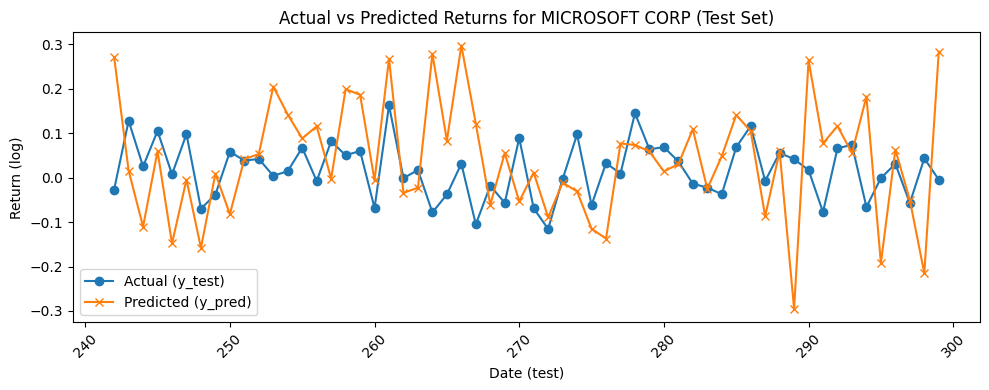

MSE: 0.020205788135463778
MAE: 0.10960441464130442
R2: -4.105901828884557


In [47]:
# Plot actual vs predicted for the test set
import matplotlib.pyplot as plt

# If you have dates for the test set, get them from the original DataFrame slice
# 'X_test' is a slice of the feature DataFrame, so its index corresponds to the test dates
try:
    test_dates = X_test.index if hasattr(X_test, 'index') else None
except NameError:
    # Fallback: try to retrieve dates from the company data using the same cutoff computed earlier
    df = sp500_monthly[comp]["data"]
    cutoff = round(len(df) * .8)
    test_dates = df.iloc[cutoff:]["date"] if "date" in df.columns else None

# Ensure y_test and y_pred are numpy arrays
import numpy as np
y_test_arr = np.asarray(y_test)
y_pred_arr = np.asarray(y_pred)

plt.figure(figsize=(10,4))
if test_dates is not None:
    plt.plot(test_dates, y_test_arr, label='Actual (y_test)', marker='o')
    plt.plot(test_dates, y_pred_arr, label='Predicted (y_pred)', marker='x')
    plt.gca().xaxis.set_tick_params(rotation=45)
else:
    plt.plot(y_test_arr, label='Actual (y_test)', marker='o')
    plt.plot(y_pred_arr, label='Predicted (y_pred)', marker='x')

plt.title(f'Actual vs Predicted Returns for {comp} (Test Set)')
plt.xlabel('Date (test)') if test_dates is not None else plt.xlabel('Test index')
plt.ylabel('Return (log)')
plt.legend()
plt.tight_layout()
plt.show()

# Small diagnostics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print('MSE:', mean_squared_error(y_test_arr, y_pred_arr))
print('MAE:', mean_absolute_error(y_test_arr, y_pred_arr))
print('R2:', r2_score(y_test_arr, y_pred_arr))

**PCR**

In [48]:
pcr_score = sp500_monthly[comp]["models"]["PCR"].score(X_test_scaled, y_test)
y_pred = sp500_monthly[comp]["models"]["PCR"].predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.0016848020494273288
MAE: 0.03391453505198842
R²: 0.5742589297775986


**LASSO**

In [49]:
lasso_score = sp500_monthly[comp]["models"]["LASSO"].score(X_test_scaled, y_test)
y_pred = sp500_monthly[comp]["models"]["LASSO"].predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.0005783371305114965
MAE: 0.01870484573868607
R²: 0.8538570931956019


**XGBoost**

In [50]:
xgb_score = sp500_monthly[comp]["models"]["XGB"].score(X_test_scaled, y_test)
y_pred = sp500_monthly[comp]["models"]["XGB"].predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.000550561676426613
MAE: 0.019175942819188333
R²: 0.8608758118349998


**FNN**

In [51]:
fnn_model = sp500_monthly[comp]["models"]["FNN"]
fnn_model.eval()

with torch.no_grad(): # no gradient tracking during prediciton
    y_pred = fnn_model(torch.tensor(X_test_scaled, dtype=torch.float32)).detach().numpy().flatten()

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.004307276734495101
MAE: 0.05399995150966518
R²: -0.08842733620326815


**LSTM**

#### Grabbing OLS Coeffs

In [98]:
#Collecting the OLS Coefficients for each company
from sklearn.preprocessing import StandardScaler

ols_coefs = []

for name in sp500_monthly:
    comp_coefs = pd.Series(sp500_monthly[name]["models"]["OLS"].coef_)
    major_group = sp500_monthly[name]["data"]["Major Group"].unique()[0]
    major_group = pd.Series([major_group], index=["Major Group"])
    comp_name = pd.Series([name], index=["Comnam"])
    comp_coefs = pd.concat([comp_name, major_group, comp_coefs])
    ols_coefs.append(comp_coefs)

ols_coefs = pd.DataFrame(ols_coefs)
ols_coefs.columns = ['Comp_name', 'Major Group','b-mktrf', 'b-smb', 'b-hml', 'b-rmw', 'b-cma', 'b-rf',
                     'b-momentum_12m', 'b-volatility']

scaler = StandardScaler()

ols_coefs.iloc[:, 2:] = scaler.fit_transform(ols_coefs.iloc[:, 2:])

ValueError: Length mismatch: Expected axis has 214 elements, new values have 10 elements

In [9]:
ols_coefs[np.absolute(ols_coefs['b-mktrf']) >= 3]

,Comp_name,Major Group,b-mktrf,b-smb,b-hml,b-rmw,b-cma,b-rf,b-momentum_12m,b-volatility
6,A M R CORP DEL,45,6.568628,0.094471,-0.183066,0.192466,3.686576,0.589355,0.775911,-0.850996
237,COMPASS BANCSHARES INC,67,-3.243215,-0.034478,1.356322,-0.206841,-0.954355,0.098069,0.150124,1.387924
246,CONEXANT SYSTEMS INC,36,4.471905,1.111871,0.278772,1.790500,-2.154334,-0.753687,-1.303467,-1.466019
249,CONSECO INC,63,3.848716,-1.462734,7.077859,-1.496256,-2.907700,1.851201,-1.046395,0.166263
266,COUNTRYWIDE CREDIT INDS INC,61,-3.355791,-1.251707,1.100426,-2.414694,0.208769,1.023988,-5.655072,1.206841
288,DELPHI CORP,37,5.822018,2.891967,1.582239,2.080055,-1.877475,0.651479,-2.769020,-5.591068
457,HEALTHSOUTH CORP,80,3.405480,1.697483,-1.767465,3.139323,2.008094,1.091287,-0.185421,-2.601222
601,MASSEY ENERGY CO,12,3.392467,-2.091893,-1.233434,0.935937,-0.283314,-2.849830,0.617619,0.699876
668,NAVIENT CORP,99,3.128003,2.531407,0.240424,0.855987,2.151803,-0.001560,-0.107964,-1.068902
715,P M C SIERRA INC,36,3.334412,0.951806,-4.093194,-1.904352,2.025897,-0.094844,0.420753,-0.094020


### Basic Industry Grouped Graphing

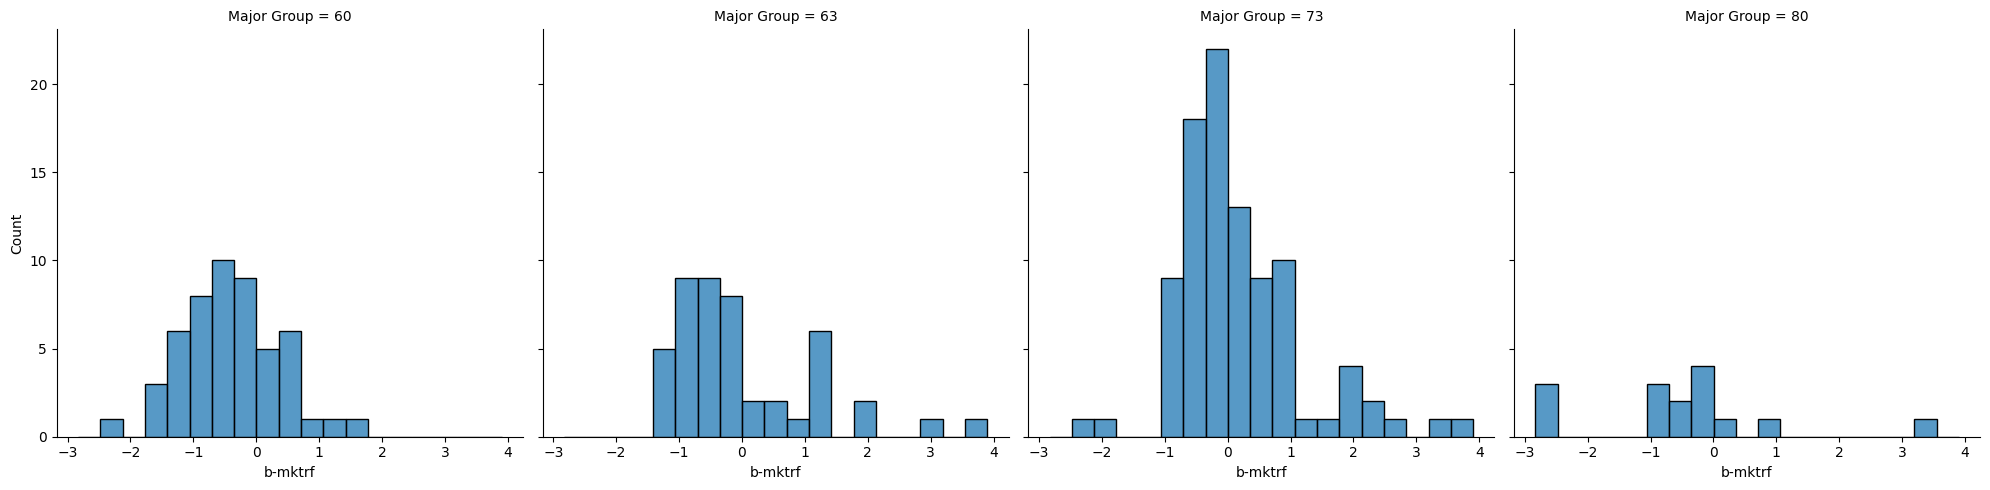

In [10]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# ind_coefs = ols_coefs[ols_coefs["Major Group"].isin(
#     list(range(50, 60)) + [60, 63, 70, 80]
# )] INCLUDES RETAIL

# ind_coefs.loc[ind_coefs["Major Group"].between(50, 59), "Major Group"] = 59 MERGE RETAIL

ind_coefs = ols_coefs[ols_coefs["Major Group"].isin([60, 63, 73, 80])]

sns.displot(ind_coefs, x="b-mktrf", col="Major Group")

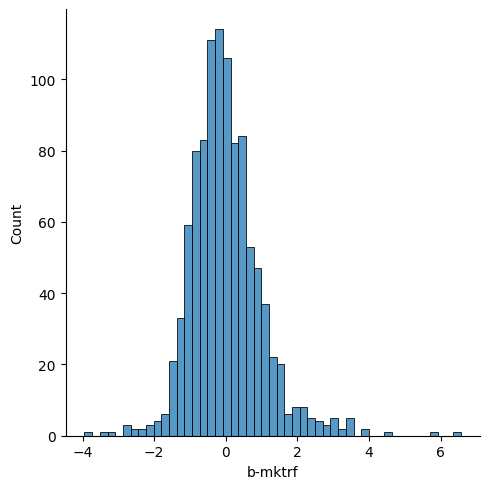

In [11]:
sns.displot(ols_coefs, x="b-mktrf")

### Finding Outlier Timeperiods & Removing From Monthly

In [10]:
#just using GE as a proxy since it has observations for every month of my timeframe
temp = sp500_monthly["GENERAL ELECTRIC CO"]["data"] 

temp['month'] = temp['date'].dt.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

temp['month'] = pd.Categorical(temp['month'], categories=month_order, ordered=True)

print(temp)

          date  Major Group       ret     mktrf       smb       hml       rmw  \
10  2000-11-01           35 -0.100684 -0.113602 -0.005943  0.126947  0.143560   
11  2000-12-01           35 -0.030022  0.011862  0.030382  0.067429  0.014604   
12  2001-01-01           35 -0.041690  0.033040  0.050929 -0.054106 -0.057914   
13  2001-02-01           35  0.011247 -0.106025  0.029075  0.128849  0.096562   
14  2001-03-01           35 -0.101578 -0.075398  0.022983  0.063095  0.034081   
..         ...          ...       ...       ...       ...       ...       ...   
295 2024-08-01           35  0.025636  0.015823 -0.035579 -0.011704  0.006412   
296 2024-09-01           35  0.078426  0.017199 -0.009971 -0.026891  0.000638   
297 2024-10-01           35 -0.093308 -0.009547 -0.008098  0.008430 -0.015303   
298 2024-11-01           35  0.058669  0.062820  0.044137  0.000962 -0.025044   
299 2024-12-01           35 -0.086503 -0.032146 -0.040471 -0.031155  0.016400   

          cma        rf  mo

In [13]:
#finding the outliers programatically

def get_month_outliers(comp):

    outliers = []
    
    for month, group in comp.groupby("month"):
        q1 = group["mktrf"].quantile(0.25)
        q3 = group["mktrf"].quantile(0.75)
        iqr = q3 - q1
    
        lower = q1 - 1.75 * iqr 
        upper = q3 + 1.75 * iqr

        print(lower)
        print(upper)
        
        month_outliers = group[(group["mktrf"] < lower) | (group["mktrf"] > upper)].copy()
    
        # Add month info
        month_outliers['month'] = month
    
        # Add outlier type info
        month_outliers['outlier_type'] = month_outliers['mktrf'].apply(
            lambda x: 'low' if x < lower else 'high'
        )
    
        outliers.append(month_outliers)
    
    # Combine all outliers into one DataFrame
    outliers_df = pd.concat(outliers).sort_values(by=['date'])
    
    # Optionally: get list of unique outlier dates
    outlier_dates = outliers_df["date"].unique()
    
    return outliers_df, outlier_dates

In [14]:
outliers_df, outliers_dates = get_month_outliers(temp)

print(outliers_dates)

-0.1414653132605248
0.14027373834501178
-0.12489793096620515
0.13480163951812574
-0.08009148431538689
0.1006143464623485
-0.0811508594052754
0.11746379697575796
-0.06626306565585544
0.08935504552354204
-0.09388802870958722
0.1009061017098255
-0.09769293491154851
0.12544799990791897
-0.11384828235065464
0.11135224470901015
-0.1638199186142355
0.1369191100181825
-0.13602144806473881
0.16070299524776113
-0.06670357305023802
0.12026742887004332
-0.05541362855329108
0.08081763113396957
<DatetimeArray>
['2000-11-01 00:00:00', '2002-12-01 00:00:00', '2008-10-01 00:00:00',
 '2008-11-01 00:00:00', '2010-05-01 00:00:00', '2018-12-01 00:00:00',
 '2019-05-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00',
 '2022-04-01 00:00:00', '2022-12-01 00:00:00']
Length: 11, dtype: datetime64[ns]


**ADDING JITTER TO HIGH VOLATILITY MONTHS**

In [19]:
### Adding jitter to high volatility months to see if any changes/fluctuations in IQR cutoff

#draw from a half normal distribution as opposed to a full normal (abs val of normal)
# Take the high volatiliyt months, set them to upper/lower bound and then add jitter to induce noise -- 10% IQR

np.random.seed(12)

jittered = temp

# Choose only the months that appear in the outliers list
mask = jittered["date"].isin(outliers_df["date"])

jittered.loc[mask, "mktrf"] += np.random.normal(loc = 0, scale = .008, size = mask.sum())

new_outliers_df, new_outliers_dates = get_month_outliers(jittered)

print(new_outliers_dates)

<DatetimeArray>
['2000-11-01 00:00:00', '2002-12-01 00:00:00', '2008-10-01 00:00:00',
 '2008-11-01 00:00:00', '2010-05-01 00:00:00', '2018-12-01 00:00:00',
 '2019-05-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00',
 '2022-12-01 00:00:00']
Length: 10, dtype: datetime64[ns]


C:\Users\nils\AppData\Local\Temp\ipykernel_2136\1895341189.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for month, group in comp.groupby("month"):


In [40]:
sp500_monthly_nout = {}

for name, dic in sp500_monthly.items():

    df = sp500_monthly[name]["data"].copy()
    
    #remove rows from temp whose date is in outlier_dates
    df = df[~df["date"].isin(outlier_dates)]

    if df.empty or len(df) < 2:
        continue #skip if too few data points left to fit a model

    sp500_monthly[name]["data"] = df

    sp500_monthly_nout[name] = {
        "data" : df,
        "models" : {}
    }

    X = monthly_df.iloc[:, 3:] #skip first three columns (date, major group, and returns)
    Y = monthly_df["ret"]
    
    lin_model = LinearRegression().fit(X,Y)
    lasso_model = Lasso().fit(X,Y)

    sp500_monthly_nout[name]["models"] = {
        "OLS": lin_model,
        "LASSO": lasso_model#,
        # "PCR": pcr_model
    }

In [51]:
list(sp500_monthly.keys())

['3M CO',
 'A D C TELECOMMUNICATIONS INC',
 'A D T CORP',
 'A E S CORP',
 'A G L RESOURCES INC',
 'A K STEEL HOLDING CORP',
 'A M R CORP DEL',
 'A O L TIME WARNER INC',
 'A P A CORP',
 'A T & T CORP',
 'A T & T INC',
 'A T & T WIRELESS SVCS INC',
 'ABBOTT LABORATORIES',
 'ABBVIE INC',
 'ABERCROMBIE & FITCH CO',
 'ABIOMED INC',
 'ACCENTURE PLC IRELAND',
 'ACE LTD',
 'ACE LTD NEW',
 'ACTIVISION BLIZZARD INC',
 'ADOBE INC',
 'ADOBE SYSTEMS INC',
 'ADVANCE AUTO PARTS INC',
 'ADVANCED MICRO DEVICES INC',
 'AETNA INC NEW',
 'AFFILIATED COMPUTER SERVICES INC',
 'AFFILIATED MANAGERS GROUP INC',
 'AFLAC INC',
 'AGILENT TECHNOLOGIES INC',
 'AIR PRODUCTS & CHEMICALS INC',
 'AIRGAS INC',
 'AKAMAI TECHNOLOGIES INC',
 'ALASKA AIRGROUP INC',
 'ALBEMARLE CORP',
 'ALBERTO CULVER CO',
 'ALBERTSONS INC',
 'ALCOA INC',
 'ALEXANDRIA REAL EST EQUITIES INC',
 'ALEXION PHARMACEUTICALS INC',
 'ALIGN TECHNOLOGY INC',
 'ALLEGHENY ENERGY INC',
 'ALLEGHENY TECHNOLOGIES',
 'ALLEGION PLC',
 'ALLERGAN INC',
 'ALLERGA

In [42]:
dat = sp500_monthly["3M CO"]["data"]
X = dat.iloc[:, 3:]
y = dat["ret"]
r_squared = sp500_monthly["3M CO"]["models"]["OLS"].score(X, y)

r_squared

0.4608343907432483

In [43]:
dat = sp500_monthly_nout["3M CO"]["data"]

X = dat.iloc[:, 3:]
y = dat["ret"]
r_squared = sp500_monthly_nout["3M CO"]["models"]["OLS"].score(X, y)

r_squared

0.25003669308194065

In [ ]:
# Can develop martingale tests over time to see if there is a bias towards certain industry returns
# Quantile Regression